### Solar Disaggregation Sensitivity Analysis


In [1]:
import numpy as np
import pandas as pd
import csss
import sqlalchemy as sq
import matplotlib.pyplot as plt
import pytz
import datetime as dt
import pickle as pk
from imp import reload
import copy


% matplotlib inline

## Load Data
Load home and weather data, previously stored in Pickle files. 

Cursory plots shows that a some homes exhibit very correlated furnace and air conditioning energy use, possbily the use of fans in ducts. I may need to create a method for filtering out the furnace use that is associated with cooling. Possibly all heating use that is simultaneous with cooling is also cooling. 

There is also cooling consumption in February in some homes, it could be that the opposite is true, and for some homes fans are included on the air conditioning circuit. 

In [2]:
loaddata = pk.load(open('data/demand.pkl', 'rb'))
homeids = np.unique(loaddata['dataid'])
print('There are %d homes in the dataset' % len(homeids))

There are 200 homes in the dataset


In [3]:
## Make a heating and cooling column
loaddata['cooling'] = np.sum(loaddata[['air1','air2','air3','airwindowunit1']], axis = 1)
loaddata['heating'] = np.sum(loaddata[['furnace1','furnace2']], axis = 1)

In [4]:
loadgroup = loaddata[['dataid','use','gen','heating','cooling']].groupby("dataid")
loaddata_counts = loadgroup.count()
loaddata_means  = loadgroup.mean()
loaddata_counts.columns = ['count_' + d for d in loaddata_counts.columns]
loaddata_means.columns  = ['mean_' + d for d in loaddata_means.columns]
load_summary = pd.concat([loaddata_counts,loaddata_means], axis = 1)

In [5]:
load_summary = load_summary.loc[load_summary['count_use'] == np.max(load_summary['count_use']),:]

In [6]:
print('There are %d homes with complete data' % load_summary.shape[0])
print('%d homes solar' % np.sum(load_summary['count_gen']>0))
print('%d homes cooling' % np.sum(load_summary['count_cooling']>0))
print('%d homes heating' % np.sum(load_summary['count_heating']>0))

There are 89 homes with complete data
52 homes solar
82 homes cooling
63 homes heating


(735785.0, 735786.0)

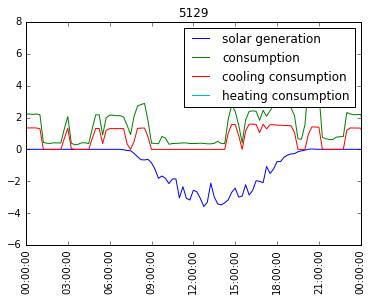

In [7]:
## Do a quick plot of load data
fig = plt.figure()
ax = plt.gca()

dataid = np.random.choice(load_summary.index, size=1)[0]

data = loaddata.groupby('dataid').get_group(dataid)

ax.plot(data['local_15min'],-data['gen'], label = 'solar generation')
ax.plot(data['local_15min'],data['use'], label = 'consumption')
ax.plot(data['local_15min'],data['cooling'], label = 'cooling consumption')
ax.plot(data['local_15min'],data['heating'], label = 'heating consumption')
ax.set_title(dataid)
ax.legend()

plt.xticks(rotation = 90)

start = dt.datetime(2015,7,6)
dur   = dt.timedelta(days = 1)

ax.set_xlim(start, start + dur)

## Climate Data
Load Appropriate Climate Data from Pecan Street.  There is no way to identify which homes belong to which datase.  There are only three locations, I'll pull all of them. 

In [8]:
weather = pk.load(open('data/weather.pkl', 'rb'))
weather.head()

,localhour,latitude,longitude,tz_offset,summary,ozone,ozone_error,temperature,temperature_error,dew_point,...,wind_speed,wind_speed_error,cloud_cover,cloud_cover_error,wind_bearing,precip_intensity,precip_intensity_error,precip_probability,precip_type,Location
0,2015-08-23 13:00:00-05:00,40.027278,-105.256111,-6,Clear,287.11,None,67.27,None,41.72,...,2.15,None,0.13,None,66,0.0,None,0.0,None,Boulder
1,2015-09-06 03:00:00-05:00,40.027278,-105.256111,-6,Clear,276.72,None,65.97,None,43.65,...,2.05,None,0.07,None,269,0.0,None,0.0,None,Boulder
2,2015-09-25 22:00:00-05:00,40.027278,-105.256111,-6,Clear,263.95,None,63.46,None,41.04,...,0.89,None,0.00,None,160,0.0,None,0.0,None,Boulder
3,2015-09-25 23:00:00-05:00,40.027278,-105.256111,-6,Clear,262.46,None,61.34,None,41.05,...,0.68,None,0.00,None,220,0.0,None,0.0,None,Boulder
4,2015-09-26 10:00:00-05:00,40.027278,-105.256111,-6,Clear,248.03,None,60.14,None,39.87,...,0.32,None,0.00,None,43,0.0,None,0.0,None,Boulder


## Create Weather Regressors

In [9]:
def createTempInput(temp, size, minTemp=None, maxTemp=None):
    if (minTemp is None):
        minTemp=min(temp)
    if maxTemp is None:
        maxTemp=max(temp)
    minBound=int(np.floor(minTemp / size)) * size
    maxBound=int(np.floor(maxTemp / size)) * size + size
    rangeCount=int((maxBound-minBound) / size)
    result=[]
    for elem in temp:
        fullRanges = min( int(np.floor((elem-minBound) / size)), rangeCount-1)
        bound      = (minBound+fullRanges*size)
        lastRange  = elem-bound
        res        = [size for elem in range(fullRanges)]
        res.append(lastRange)
        for var in range(rangeCount-fullRanges-1):
            res.append(0)
        res.append(1)
        result.append(res)
    return minBound, maxBound,result


weatherAustin = weather.groupby("Location").get_group("Austin").sort_values("localhour")
weatherAustin['time'] = pd.to_datetime(weatherAustin['localhour'], utc = True)
#weatherAustin["time"] = weatherAustin.set_index("localhour").index.tz_localize(pytz.utc, ambiguous = False)
weatherAustin = weatherAustin.set_index("time")


### Set up an example Solar Disaggregation on multiple homes

## Create the individual homes model
This code creates the CSSS model for disaggregating solar at individual homes. 
This is the training problem, not the real time problem. 
See note below on issues with values of alpha. 

### Alpha and solver errors
The solver is sensitive to large values of alpha, particularly with more data.  There seems to be an inverse relationship between the maximum size of alpha and the amount of data. The errors scale with t he magnitude of alpha, not the difference between alphas, so by scaling the maximum alpha to 1, we may solve this problem. 

In [51]:
## Choose homes 
Nhomes = 8

## Identify dataids to use
dataids = np.random.choice( load_summary.index[load_summary['count_gen']>0] , Nhomes, replace=False)
proxyids = dataids[:1]   # Homes to be used as solar proxy
tuneids  = dataids[1:4]  # Home to be used for tuning
homeids = dataids[1:]    # Homes to be used for disaggregation

## Set up data 
first = True
for did in dataids:
    dat = loaddata.groupby("dataid").get_group(did).set_index('time')[['use','gen']]
    dat['netload_%s' % did] = dat['use'] - dat['gen']
    dat.columns = ['demand_%s' % did, 'solar_%s' % did, 'netload_%s' % did]

    if first:
        fulldata = dat
        first = False
    else:
        fulldata = pd.concat([fulldata,dat], axis = 1)

## Create aggregate load and aggregate net load columns. 
netloadcols = ['netload_%s' % d for d in homeids]
loadcols    = ['demand_%s' %  d for d in homeids]
proxycol    = ['solar_%s' %   d for d in proxyids]

fulldata['AggregateNetLoad'] = np.sum(fulldata[netloadcols], axis = 1)
fulldata['AggregateLoad']    = np.sum(fulldata[loadcols], axis = 1)


In [52]:
## Time align weather data with load data using linear interpolation 
xp  = [t.value for t in weatherAustin.index ]
x = [t.value for t in fulldata.index  ]
fulldata['AustinTemp'] = np.interp(x = x ,xp=xp, fp =  weatherAustin['temperature'])

data = fulldata.iloc[:1000,:]

## Get HOD regressors
hod = pd.Series([t.hour for t in data.index])
hod = pd.get_dummies(hod)

## Get temperature regressors
Tmin, Tmax, tempregress = regressor=createTempInput(data['AustinTemp'], 10)

loadregressors = np.hstack([hod,tempregress])
netload = np.array(data[netloadcols])
solarproxy = np.array(data[proxycol])
names = ['solar_%s' % d for d in homeids]

## Construct solar disaggregation problem
reload(csss.SolarDisagg)
sdmod0 = csss.SolarDisagg.SolarDisagg_IndvHome(netloads=netload, solarregressors=solarproxy, loadregressors=loadregressors, names = names)


## add true vectors
for d in homeids:
    source_name = 'solar_%s' % d
    sdmod0.addTrueValue(name=source_name, trueValue=data[source_name])

sdmod0.constructSolve()
sdmod_tune = copy.deepcopy(sdmod0)
sdmod_tune.tuneAlphas(['solar_%s' % d for d in tuneids])
sdmod_tune.constructSolve()


solar_8243
solar_6990
solar_3918
[ 0.00041033  0.00091333  0.0011541 ]
0.000943000060574
(6.0173696751793795e-05, 1479.9532583933319)
(0.00014235731963264177, 1142.3949779630229)
(0.00015511985100294401, 2117.2072432732748)
(0.00019758890318342397, 5061.0129611969596)
(9.4355734561344003e-05, 633.37416754675166)
(9.4990025818567103e-05, 960.09014251559847)
(0.00022009318774944407, 4543.5299939333354)
(0.0056084568812425819, 178.30216424494378)


0.19283426388016361

(735601.25, 735603.25)

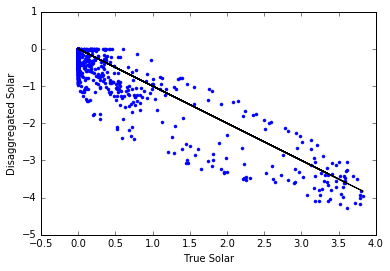

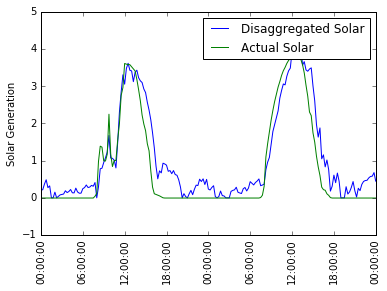

In [53]:
sdmod = copy.deepcopy(sdmod0)
i=0
source_name = sdmod.names[i]
fig = plt.figure()
ax = plt.gca()
ax.plot(sdmod.trueValues[source_name],  sdmod.models[source_name]['source'].value, '.')
ax.plot(sdmod.trueValues[source_name],  -sdmod.trueValues[source_name], 'k-')
ax.set_xlabel('True Solar')
ax.set_ylabel('Disaggregated Solar')

fig = plt.figure()
ax = plt.gca()
ax.plot(data.index,  -sdmod.models[source_name]['source'].value, '-', label = 'Disaggregated Solar')
ax.plot(data.index,  data[source_name], '-', label = 'Actual Solar')
start = dt.datetime(2015,1,3,0,0,0)
start = pytz.timezone('America/Chicago').localize(start)
ax.legend()
ax.set_ylabel('Solar Generation')
dur   = dt.timedelta(days = 2)
plt.xticks(rotation = 90)

ax.set_xlim(start, start + dur)

(735601.25, 735603.25)

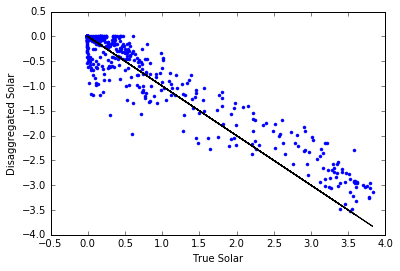

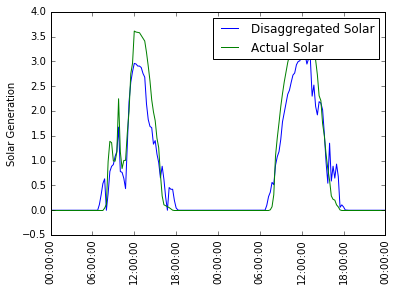

In [54]:
sdmod = copy.deepcopy(sdmod_tune)
source_name = sdmod.names[i]
fig = plt.figure()
ax = plt.gca()
ax.plot(sdmod.trueValues[source_name],  sdmod.models[source_name]['source'].value, '.')
ax.plot(sdmod.trueValues[source_name],  -sdmod.trueValues[source_name], 'k-')
ax.set_xlabel('True Solar')
ax.set_ylabel('Disaggregated Solar')

fig = plt.figure()
ax = plt.gca()
ax.plot(data.index,  -sdmod.models[source_name]['source'].value, '-', label = 'Disaggregated Solar')
ax.plot(data.index,  data[source_name], '-', label = 'Actual Solar')
start = dt.datetime(2015,1,3,0,0,0)
start = pytz.timezone('America/Chicago').localize(start)
ax.legend()
ax.set_ylabel('Solar Generation')
dur   = dt.timedelta(days = 2)
plt.xticks(rotation = 90)

ax.set_xlim(start, start + dur)

In [55]:
sdmod_tune.performanceMetrics()
sdmod0.performanceMetrics()
sdmod_tune.cv

{'solar_2755': 4.8659155565431007,
 'solar_3918': 3.2302884080319236,
 'solar_5892': 4.1459195479538993,
 'solar_6990': 4.4983757601748104,
 'solar_8243': 4.3858123451406632,
 'solar_9248': 3.4150332471131115,
 'solar_93': 6.4292701699539343}

In [56]:
sdmod0.cv

{'solar_2755': 5.0379874567583656,
 'solar_3918': 5.8169477394798621,
 'solar_5892': 5.0212024425752508,
 'solar_6990': 4.6670611079226934,
 'solar_8243': 5.0977481849817181,
 'solar_9248': 5.8100273981347366,
 'solar_93': 6.1211214421503453}

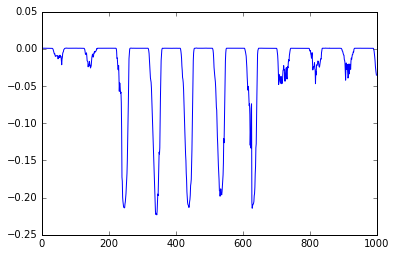

In [57]:
model_est = sdmod_tune.models['solar_3918']['regressor'] * sdmod_tune.models['solar_3918']['theta']
model_est = np.array(model_est.value).squeeze()
plt.plot(model_est)

In [58]:
sdmod_tune.models['AggregateLoad']['alpha']

array([  8.13884479e-04,   9.79515579e-04,   4.40933923e-04,
         3.38149690e-04,   1.73793969e-04,   3.85684320e-04,
         2.30994719e-04,   2.69101442e-04,   2.86549563e-04,
         2.23661953e-04,   2.24021137e-04,   2.31276260e-04,
         2.12717959e-04,   2.04961992e-04,   1.97532063e-04,
         1.84666268e-04,   1.93963806e-04,   2.09291832e-04,
         2.00870148e-04,   1.40851071e-04,   1.34251750e-04,
         1.47294620e-04,   1.34763772e-04,   9.92664772e-05,
         7.47887975e-05,   6.84527631e-05,   6.33694811e-05,
         6.11607234e-05,   6.14369172e-05,   6.15471237e-05,
         6.25527590e-05,   6.90178815e-05,   7.17975522e-05,
         7.43853113e-05,   7.52697680e-05,   9.70478131e-05,
         1.53480849e-04,   2.03288181e-04,   2.74224865e-04,
         1.97455627e-04,   1.96248456e-04,   6.39350610e-05,
         5.97763628e-05,   6.40719616e-05,   5.28967465e-05,
         4.09282456e-05,   3.17165156e-05,   2.52661019e-05,
         2.35986725e-05,

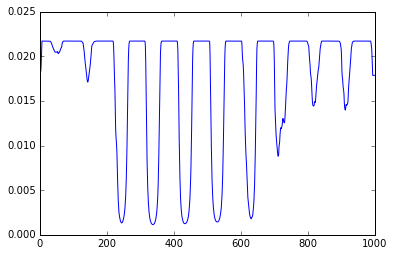

In [42]:
plt.plot(sdmod.models['solar_3918']['alpha'])

In [34]:
np.mean(np.abs(sdmod_tune.netloads['solar_3918']))

1.4056632